# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [1]:
# Initial import
import dcgpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline

### Data set

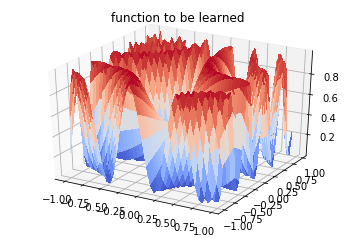

In [3]:
# To plot the unction we use a uniform grid
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
n_samples = len(X) * len(Y)
points = np.zeros((n_samples, 2))

i=0
for x in X:
    for y in Y:
        points[i][0] = x
        points[i][1] = y
        i=i+1
labels = (np.sin(5 * points[:,0] * (3 * points[:,1] + 1.)) + 1. ) / 2.
points = points.reshape((n_samples,2))
labels = labels.reshape((n_samples,1))

# To plot the function 
X, Y = np.meshgrid(X, Y)
Z = (np.sin(5 * X * (3 * Y + 1.)) + 1. ) / 2.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# We shuffle the points and labels
points, labels = shuffle(points, labels, random_state=0)
# We creat training and test sets
X_train = points[:800]
Y_train = labels[:800]
X_test = points[800:]
Y_test = labels[800:]
_ = plt.title("function to be learned")

### Mutating a dCGPANN

In [5]:
# Non linearities
# We define a single input single output dCGPANN.
dcgpann = dcgpy.encode_ffnn(2,1,[50,20],["sig", "sig", "sig"], 5)

# By default all weights (and biases) are set to 1 (and 0). We initialize them randomly
dcgpann.randomise_weights(mean = 0., std = 2.)
dcgpann.randomise_biases(mean = 0., std = 1.)

print("Starting error:", dcgpann.loss(points,labels, "MSE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))
x = dcgpann.get()
w = dcgpann.get_weights()
b = dcgpann.get_biases()
res = []


Starting error: 0.16330222789585908
Net complexity (number of active weights): 1120
Net complexity (number of unique active weights): 1120
Net complexity (number of active nodes): 73


100%|██████████| 100/100 [00:00<00:00, 231.43it/s]


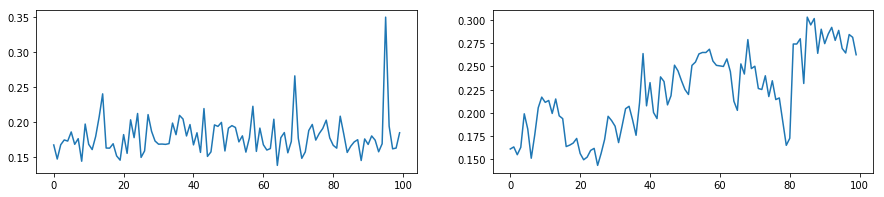

In [6]:
# We show the effect of mutations
n_mutations = 100
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(x)
    dcgpann.set_weights(w)
    dcgpann.set_biases(b)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))
    
mut2 = []
dcgpann.set(x)
dcgpann.set_weights(w)
dcgpann.set_biases(b)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(X_train,Y_train, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


In [7]:
lr0 = 0.3
for i in tqdm(range(5000)):
    lr = lr0 * np.exp(-0.0001 * i)
    dcgpann.sgd(X_train, Y_train, lr, 800, "MSE")
    res.append(dcgpann.loss(X_train,Y_train, "MSE"))

100%|██████████| 5000/5000 [00:53<00:00, 94.03it/s]


In [13]:
lr

0.1819773947434077

RMSE:  0.30967021296697095
MSE:  0.09589564079900914


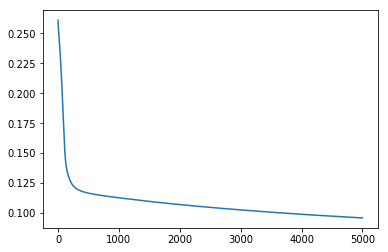

In [8]:
plt.plot(res)
print("RMSE: ", np.sqrt(res[-1]))
print("MSE: ", res[-1])

In [9]:
# We train
n_epochs = 200
print("Start error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

for i in tqdm(range(n_epochs)):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

print("Current error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

xt = dcgpann.get()
wt = dcgpann.get_weights()
bt = dcgpann.get_biases()


Start error: 0.09589564079900914


100%|██████████| 200/200 [00:01<00:00, 144.24it/s]

Current error: 0.07896770112609014


100%|██████████| 100/100 [00:00<00:00, 149.52it/s]


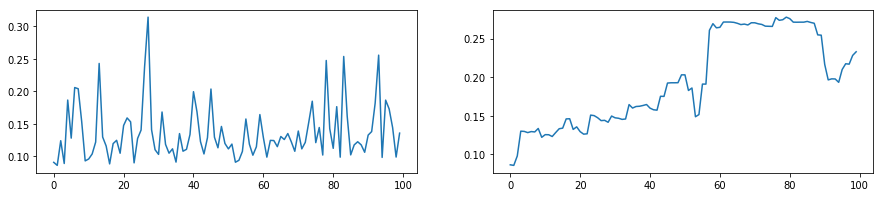

In [10]:
# We show the effect of mutations
n_mutations = 100
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(points,labels, "MSE"))
    
mut2 = []
dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(1)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(points,labels, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


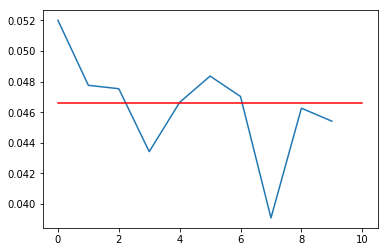

In [11]:
# We show the effect of trained mutations
n_mutations = 10
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    for i in range(1000):
        dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))

dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in range(1000):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

_ = plt.plot(mut)
_ = plt.plot([0,n_mutations],[dcgpann.loss(X_train,Y_train, "MSE"),dcgpann.loss(X_train,Y_train, "MSE")],'r')